# <font color='blue'><b> Canny Edge Detector </b></font>



In [1]:
#Impostazione progetto: importo le librerie, definisco le directories, apro e converto immagini in grayscale (semplifico esecuzione)

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from skimage.io import imread
from skimage.color import rgb2gray

work_dir= os.getcwd()
immagini = work_dir + '/Immagini/input/'

im1 = imread(immagini +  'titanic.jpg')
im2 = imread(immagini +  'shuttle.jpg')
im3 = imread(immagini +  'eiffel.jpg')
titanic = rgb2gray(im1)
shuttle = rgb2gray(im2)
eiffel = rgb2gray(im3)

### <font color='blue'>Canny con OpenCV</font>

La libreria OpenCV mette a disposizione una funzione: Canny(image, low threshold, high threshold, dim kernel Sobel) che si occupa di svolgere autonomamente tutti i passi dell'algoritmo Canny, dando in ouput la mappa degli edge corrispondente all'immagine in input


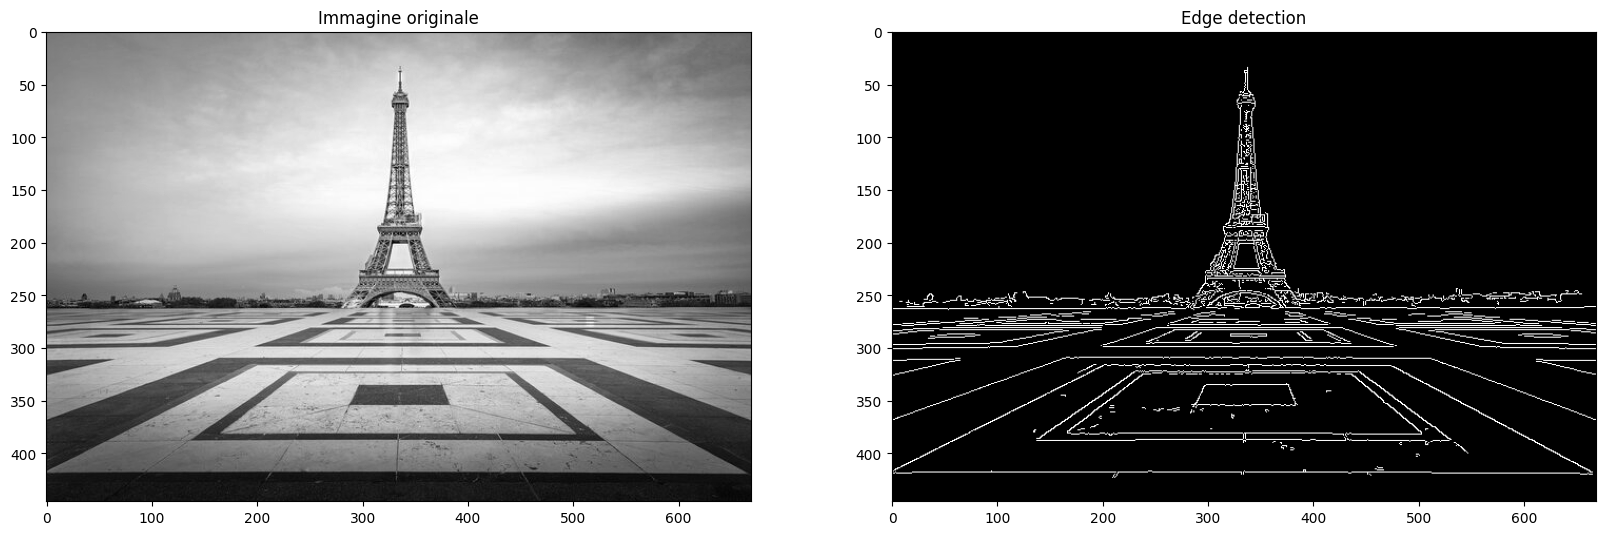

In [2]:
from skimage import img_as_ubyte

im = img_as_ubyte(eiffel)
edges = cv2.Canny(im,200,300)

plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(im,cmap = 'gray')
plt.title('Immagine originale')
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge detection')
plt.show()

### <font color='blue'>Canny Edge Detector passo dopo passo</font> 

In [8]:
def derivateofGaussian(im, sigma):
# Passi 1 e 2: smoothing con Gaussiana e calcolo direzione e modulo normalizzato del gradiente per ciascun punto (tramite Sobel)
#imput: immagine da elaborare (im) e "peso" dello smoothing con Gaussiana (sigma)
    
    dim_filtro=6*sigma + 1 #basato sulla regola delle 6 sigma: precisione del 99.999% nel rappresentare la funzione Gaussiana
    g = cv2.getGaussianKernel(dim_filtro, sigma)
    im= cv2.filter2D (im, -1, g)

    #costruisco il kernel di Sobel e lo applico alla mia immagine come primo passo dell'edge detection
    sobelX = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    sobelY = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32) 
    mapX = cv2.filter2D(im, -1, sobelX)
    mapY = cv2.filter2D(im, -1, sobelY)

    #calcolo direzione e modulo del vettore gradiente utilizzando le funzioni goniometriche e le restituisco
    dir = np.arctan2(mapY, mapX)
    modulo = np.hypot(mapX, mapY)
    modulo = modulo / modulo.max() * 255
 
    return (modulo, dir)

In [9]:
def nonMaxSuppression(Mod, Dir):
#Passo 3: non-maxima suppression
#imput: mappa dei moduli (Mod) e delle direzioni (Dir) del gradiente in ciascun punto
#output: mappa di tutti i possibili edge, ovvero i punti di massimo locale (localMaxMap)
  
    M,N = Mod.shape
    localMaxMap = np.zeros((M,N), dtype=np.int32)
    angle = Dir * 180 / np.pi
    angle[angle < 0] += 180 # "normalizzo" gli angoli negativi per riportarli nel I e II quadrante (sommando 180)
     
    for pX in range(1,M-1):
        for pY in range(1,N-1):
            try:
                #Per ciascun punto ricavo il valore del modulo del gradiente nei punti adiacenti (diversi casi a seconda della direzione)
                prev = 255
                next = 255
                
                if (0<=angle[pX,pY]<22.5) or (157.5<=angle[pX,pY]<=180):
                    #Se angolo è circa 0, considero i vicini lungo la direzione verticale
                    prev = Mod[pX, pY-1]
                    next = Mod[pX, pY+1]
                elif (22.5<=angle[pX,pY]<67.5):
                    #Se angolo è circa 45°, considero i vicini lungo la diagonale sx-dx
                    prev = Mod[pX-1, pY-1]
                    next = Mod[pX+1, pY+1]
                elif (67.5<=angle[pX,pY]<112.5):
                    #Se angolo è circa 90°, considero i vicini lungo la direzione orizzontale
                    prev = Mod[pX-1, pY]
                    next = Mod[pX+1, pY]
                elif (112.5<=angle[pX,pY]<157.5):
                    #Se angolo è circa 135°, considero i vicini lungo la diagonale dx-sx
                    prev = Mod[pX+1, pY+1]
                    next = Mod[pX-1, pY-1]

                #confronto il modulo del gradiente con quello dei suoi vicini, se è maggiore di entrambi lo considero come max locale e lo aggiungo alla mappa
                if (Mod[pX,pY]>=prev) and (Mod[pX,pY]>=next):
                    localMaxMap[pX,pY] = Mod[pX,pY]
                else:
                    localMaxMap[pX,pY] = 0

            except IndexError as e:
                pass
    
    return localMaxMap

In [10]:
def threshold(img, threshLow=20, threshHigh=100):
#Funzione di utilità che si occupa della suddivisione degli edge points tra strong e weak
#Input: immagine da analizzare (img) e valori di soglia (threshLow e threshHigh con valori di default 20 e 100)
#Output: mappa associativa che contiene la posizione tutti gli edge points con relativa etichetta numerica che li distingue tra strong e weak (edgeType)
 
    M,N = img.shape
    edgeType = np.zeros((M,N), dtype=np.int32)
    
    # Confronto il valore di ciascun punto con i valori di soglia e distinguo in questo modo weak e strong edges (tutti gli altri punti=0)
    weakX, weakY = np.where((img<=threshHigh) & (img>=threshLow))
    strongX, strongY = np.where(img>=threshHigh)
    
    # Uso 1 come etichetta numerica da associare ai weak edges, 255 per gli strong edges
    edgeType[weakX, weakY] = 1
    edgeType[strongX, strongY] = 255
    
    return (edgeType)

In [11]:
def hysteresisThresholding(img, threshLow=20, threshHigh=100):
#Passo 4: sogliatura con isteresi. I punti di edge vengono posti=1, gli altri=0
#input: immagine da elaborare (img: mappa ottenuta al passo 3) e valori di soglia (threshLow e threshHigh con valori di default)
#output: mappa binaria degli edge (edgeMap). Risultato finale dell'algoritmo di Canny

    eT = threshold(img, threshLow, threshHigh)
    M,N = eT.shape  
    
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (eT[i,j]==1):
            #Se l'edge point è weak (eT=1), verifico il valore degli 8 punti adiacenti (prev e next nelle 4 direzioni), se trovo almeno uno strong edge (eT=255), allora marco quel punto come strong edge, altrimenti come non edge
                try:
                    if ((eT[i+1,j-1]==255) or (eT[i+1,j]==255) or (eT[i+1,j+1]==255) or (eT[i,j-1]==255) or (eT[i,j+1]==255) or (eT[i-1,j-1]==255) or (eT[i-1,j]==255) or (eT[i-1,j+1]==255)):
                        eT[i, j] = 255
                    else:
                        eT[i, j] = 0
                except IndexError as e:
                    pass
    return eT

### MAIN

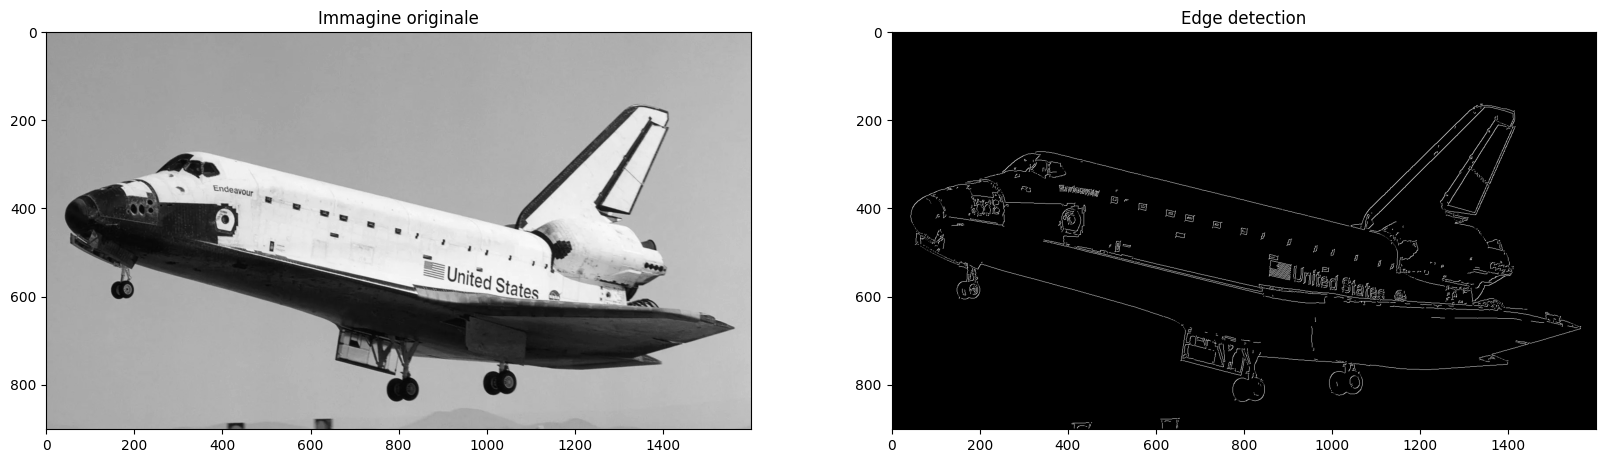

In [12]:
#Definisco i parametri di sigma e soglie da utilizzare e scelgo quale immagine elaborare (MODIFICABILI)
gaussian_sigma = 1
thresh_low= 5 
thresh_high= 40
im=shuttle

#Eseguo i vari passi andando a chiamare le funzioni definite in precedenza
[mod, dim] = derivateofGaussian(im, gaussian_sigma)
localMax = nonMaxSuppression(mod, dim)
edges = hysteresisThresholding(localMax, thresh_low, thresh_high)

#Visualizzazione del risultato confrntato con la foto originale
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(im,cmap = 'gray')
plt.title('Immagine originale')
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge detection')
plt.show() 
